In [2]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./main.ipynb
./nces330_20.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style('darkgrid')

%matplotlib inline

In [5]:
input_file = './nces330_20.csv'
df=pd.read_csv(input_file)
df.head()

,Year,State,Type,Length,Expense,Value
0,2013,Alabama,Private,4-year,Fees/Tuition,13983
1,2013,Alabama,Private,4-year,Room/Board,8503
2,2013,Alabama,Public In-State,2-year,Fees/Tuition,4048
3,2013,Alabama,Public In-State,4-year,Fees/Tuition,8073
4,2013,Alabama,Public In-State,4-year,Room/Board,8473


In [6]:
target = 'Value'

In [7]:
df.describe()

,Year,Value
count,3548.000000,3548.000000
mean,2016.923337,13027.720124
std,2.553910,8734.568645
min,2013.000000,1225.000000
25%,2015.000000,7756.750000
50%,2017.000000,10203.500000
75%,2019.000000,14830.750000
max,2021.000000,49152.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     3548 non-null   int64 
 1   State    3548 non-null   object
 2   Type     3548 non-null   object
 3   Length   3548 non-null   object
 4   Expense  3548 non-null   object
 5   Value    3548 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 166.4+ KB


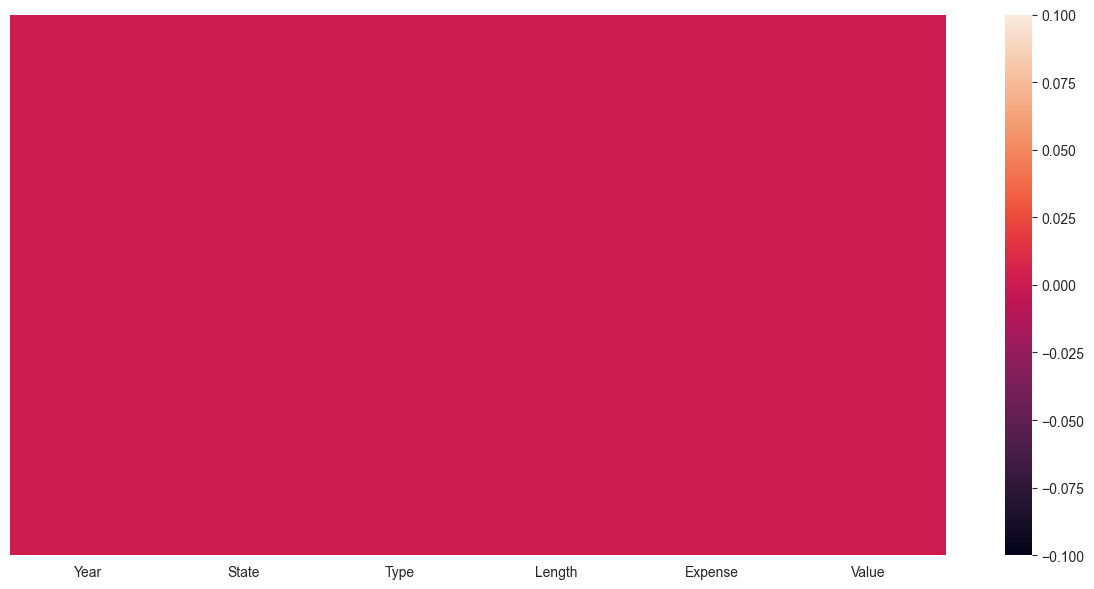

In [9]:
#Check Null State
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), yticklabels=False)
plt.tight_layout()

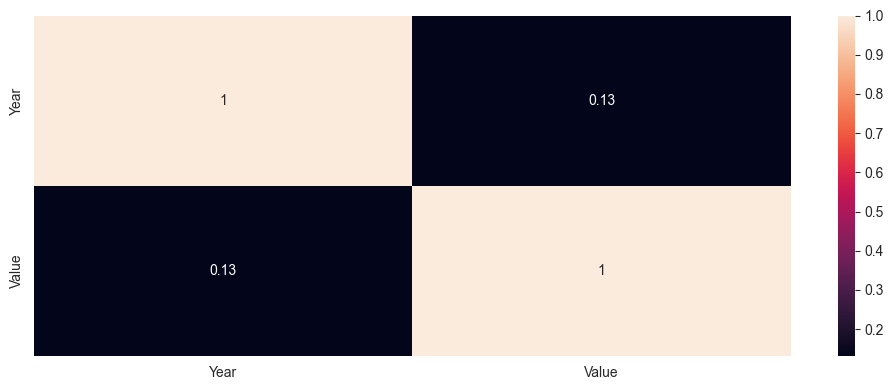

In [10]:
plt.figure(figsize=(10,4))
sns.heatmap(df.corr(), annot=True)
plt.tight_layout()

In [19]:
cat_col_large=[]
# print(df.select_dtypes(include='object'))
for col in df.select_dtypes(include='object'):
    if(col!=target and df[col].nunique()>20):
        print(f"{col:20} -----> {df[col].nunique():10} unique values")
        cat_col_large.append(col)
cat_col_large
    

State                ----->         51 unique values


['State']

In [41]:
cat_col=[]
for col in df.select_dtypes(include='object'):
    if(col!=target and col not in cat_col_large):
        print(f"{col:20} ----> {df[col].nunique():10} unique values")
        cat_col.append(col)
cat_col

Type                 ---->          3 unique values
Length               ---->          2 unique values
Expense              ---->          2 unique values


['Type', 'Length', 'Expense']

In [42]:
num_col=[]
for col in df.columns:
    if(col!=target and col not in (cat_col+cat_col_large)):
        print(f"{col:30} ----> {df[col].nunique():10} unique values")
        num_col.append(col)
num_col

Year                           ---->          9 unique values


['Year']

In [43]:
len(cat_col),len(cat_col_large),len(num_col)

(3, 1, 1)

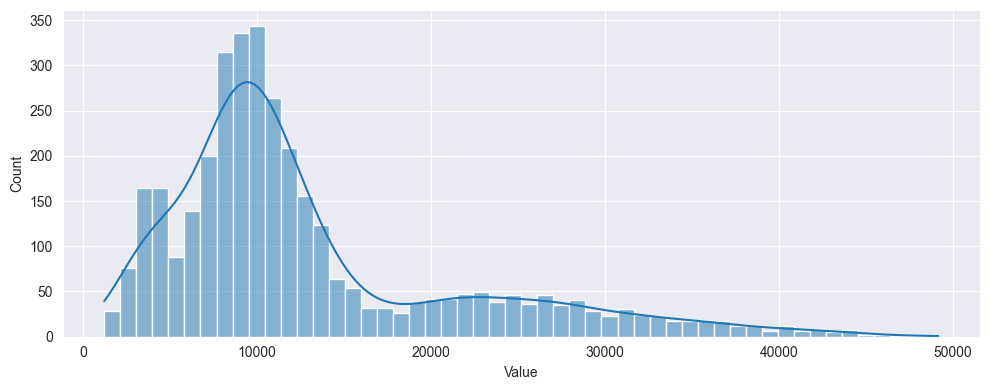

In [44]:
plt.figure(figsize=(10,4))
sns.histplot(data=df, x=target, kde=True, palette='tab10')
plt.tight_layout()

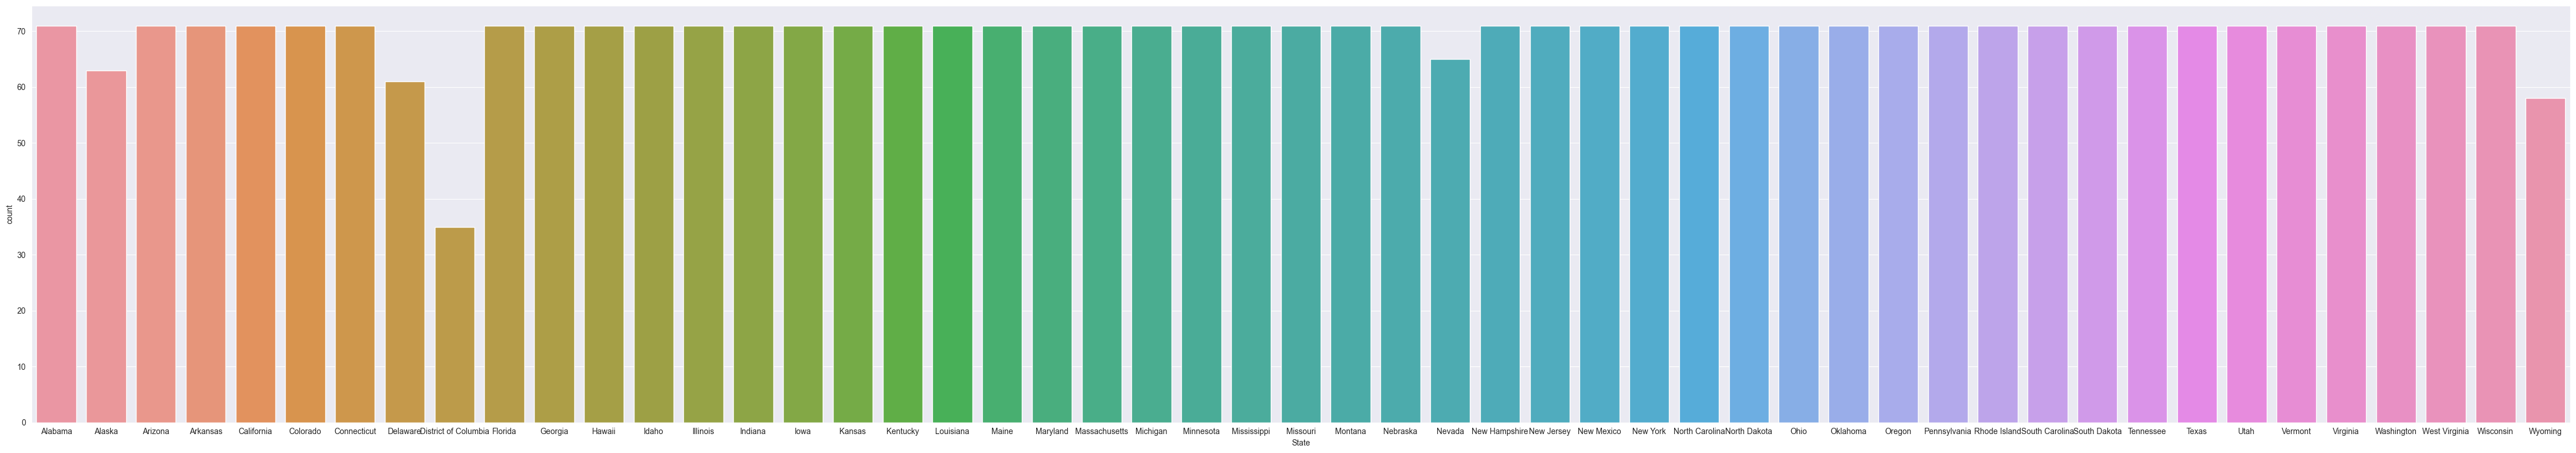

In [45]:
plt.figure(figsize=(45,8))
j=1
for colomns in cat_col_large:
    plt.subplot(1,1,j)
    sns.countplot(x=colomns, data=df)
    j+=1
plt.tight_layout()

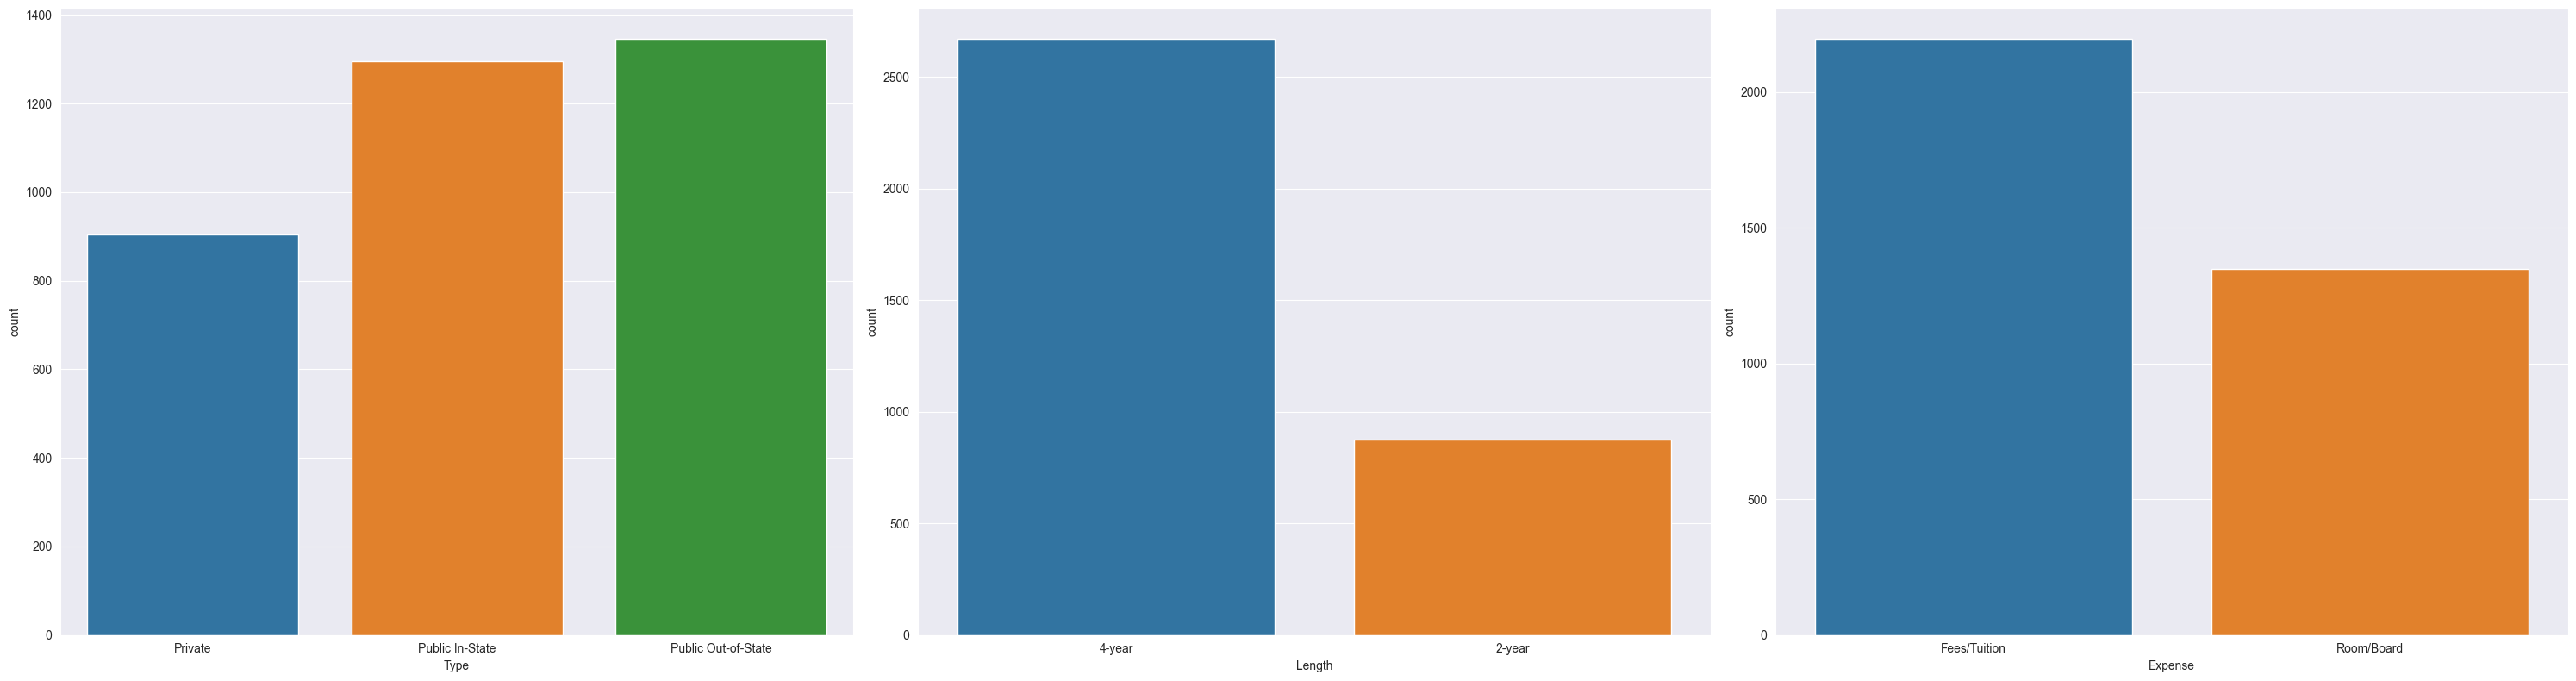

In [51]:
plt.figure(figsize=(30,8))
j=1
for columns in cat_col:
    plt.subplot(1,len(cat_col),j)
    sns.countplot(x=columns,data=df)
    j+=1
plt.tight_layout()

In [50]:
print(len(cat_col))

3


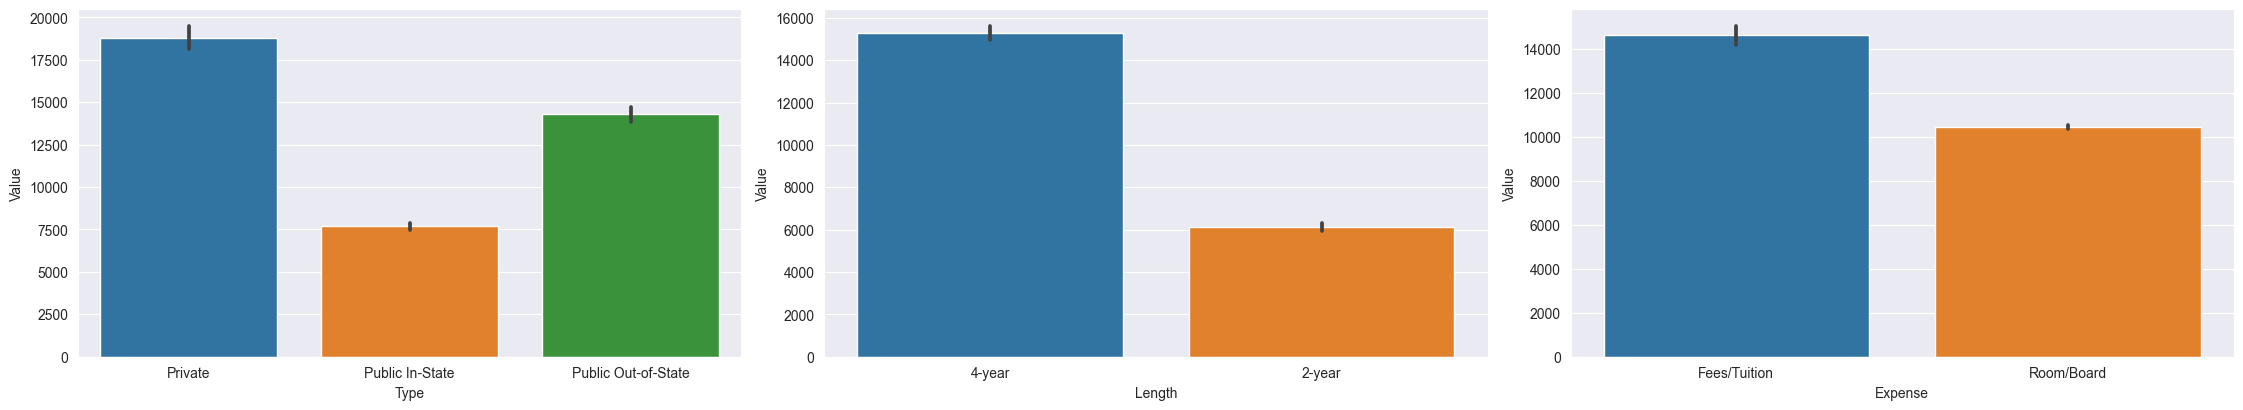

In [53]:
plt.figure(figsize=(30,20))
j=1
for columns in cat_col:
    plt.subplot(5,4,j)
    sns.barplot(y=target,x=columns,data=df)
    j+=1
plt.tight_layout()

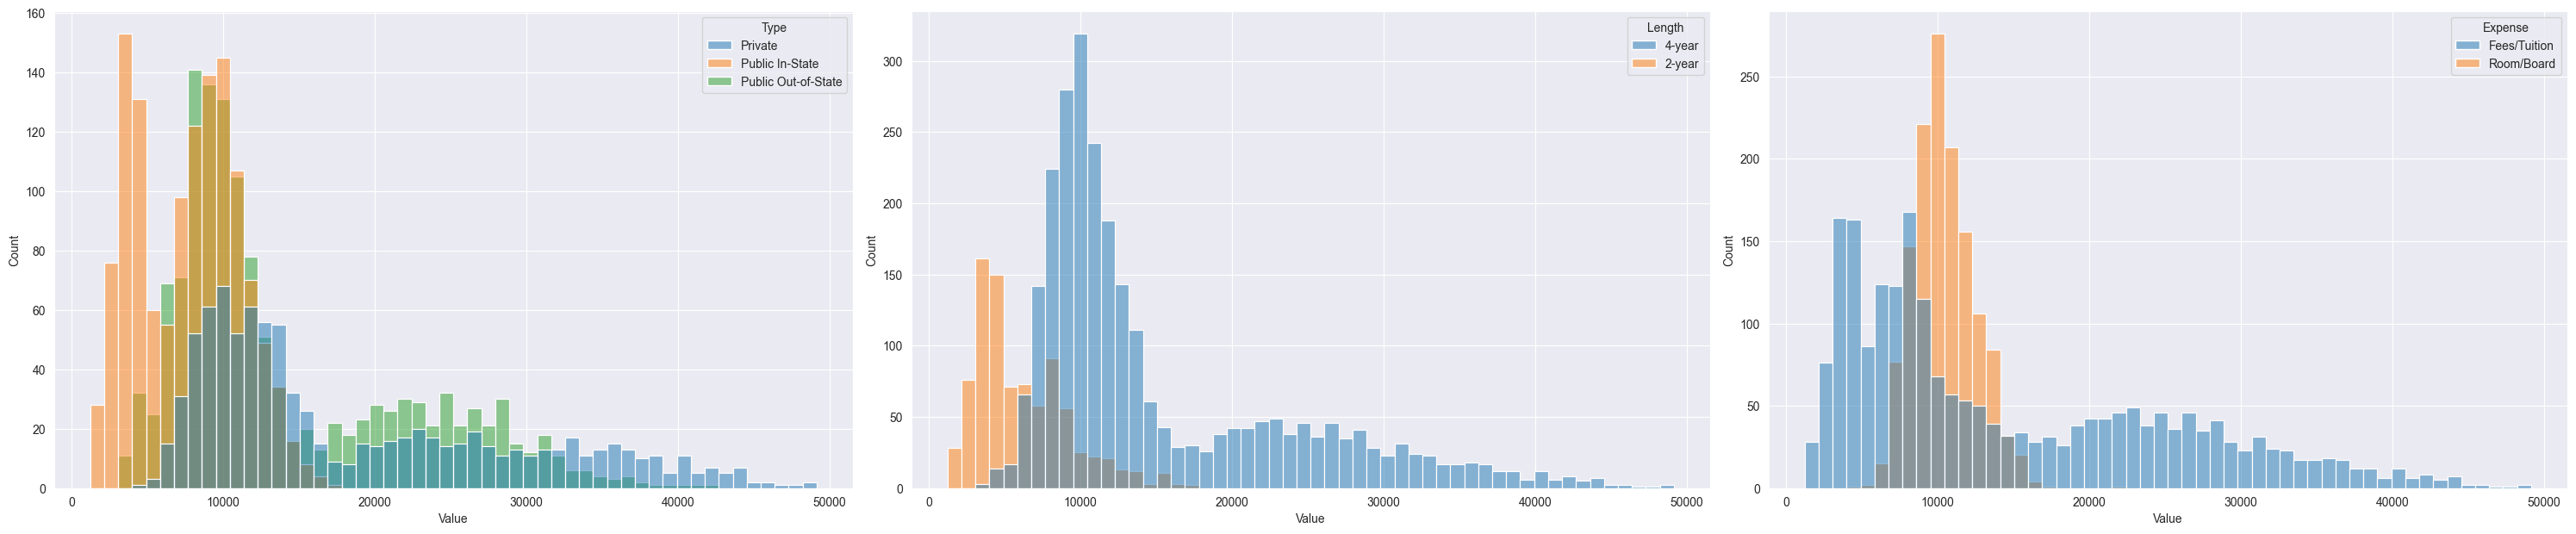

In [49]:
plt.figure(figsize=(30,12))
j=1
for columns in cat_col:
    plt.subplot(2,3,j)
    sns.histplot(x=target,data=df,hue=columns)
    j+=1
plt.tight_layout()

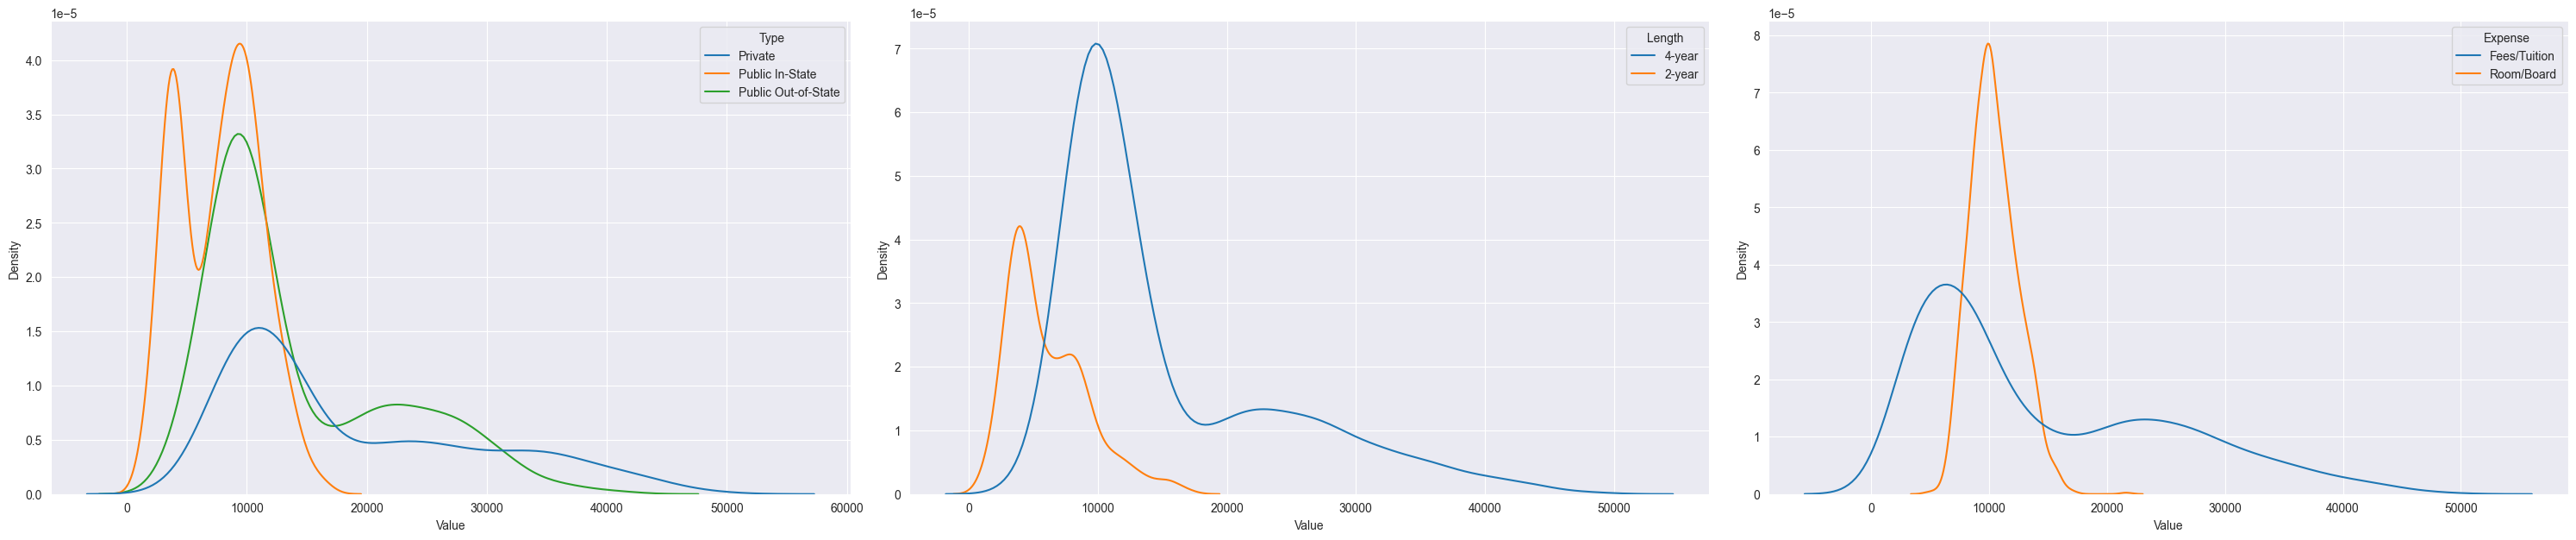

In [54]:
plt.figure(figsize=(30,12))
j=1
for columns in cat_col:
    plt.subplot(2,3,j)
    sns.kdeplot(x=target,data=df,hue=columns)
    j+=1
plt.tight_layout()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     3548 non-null   int64 
 1   State    3548 non-null   object
 2   Type     3548 non-null   object
 3   Length   3548 non-null   object
 4   Expense  3548 non-null   object
 5   Value    3548 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 166.4+ KB


In [56]:
oh = OneHotEncoder(drop='first', handle_unknown='ignore')
mm, ss = MinMaxScaler(), StandardScaler()

ct=ColumnTransformer(
    [
        ('cat_encoder', oh, make_column_selector(dtype_include='object'))
    ],
    remainder='passthrough',
    n_jobs=-1
)
ct

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('cat_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000176007DCB50>)])

In [57]:
df.head(1)

,Year,State,Type,Length,Expense,Value
0,2013,Alabama,Private,4-year,Fees/Tuition,13983


In [58]:
X=df.drop([target], axis=1)
y=df[[target]]
X.head(1)

,Year,State,Type,Length,Expense
0,2013,Alabama,Private,4-year,Fees/Tuition


In [59]:
y.head(1)

,Value
0,13983


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [62]:
X_train.shape, y_train.shape

((2838, 5), (2838, 1))

In [63]:
X_test.shape, y_test.shape

((710, 5), (710, 1))

In [67]:
X_test.head(2)

,Year,State,Type,Length,Expense
299,2013,Oregon,Public Out-of-State,4-year,Room/Board
2550,2019,Louisiana,Public In-State,4-year,Fees/Tuition


In [68]:
y_test.head(2)

,Value
299,10232
2550,9358


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     3548 non-null   int64 
 1   State    3548 non-null   object
 2   Type     3548 non-null   object
 3   Length   3548 non-null   object
 4   Expense  3548 non-null   object
 5   Value    3548 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 166.4+ KB


In [70]:
X_train=ct.fit_transform((X_train))
X_test=ct.transform(X_test)

In [71]:
print("-"*50)
for i in ct.transformers_:
    print(i)
    if(i[0]!='remainder'):
        print(i[1].get_feature_names_out())   
    print("-"*50)

--------------------------------------------------
('cat_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), ['State', 'Type', 'Length', 'Expense'])
['State_Alaska' 'State_Arizona' 'State_Arkansas' 'State_California'
 'State_Colorado' 'State_Connecticut' 'State_Delaware'
 'State_District of Columbia' 'State_Florida' 'State_Georgia'
 'State_Hawaii' 'State_Idaho' 'State_Illinois' 'State_Indiana'
 'State_Iowa' 'State_Kansas' 'State_Kentucky' 'State_Louisiana'
 'State_Maine' 'State_Maryland' 'State_Massachusetts' 'State_Michigan'
 'State_Minnesota' 'State_Mississippi' 'State_Missouri' 'State_Montana'
 'State_Nebraska' 'State_Nevada' 'State_New Hampshire' 'State_New Jersey'
 'State_New Mexico' 'State_New York' 'State_North Carolina'
 'State_North Dakota' 'State_Ohio' 'State_Oklahoma' 'State_Oregon'
 'State_Pennsylvania' 'State_Rhode Island' 'State_South Carolina'
 'State_South Dakota' 'State_Tennessee' 'State_Texas' 'State_Utah'
 'State_Vermont' 'State_Virginia' 'State_Washingto

In [73]:
X_train.shape,y_train.shape

((2838, 55), (2838, 1))

In [74]:
tup1=None;tup2=None
try:
    tup1=(X_test[0].toarray(),y_test.head(1).values)  # scientific notation
    print("Sparse Matrix to Dense Array")
except:
    tup2=(X_test[0],y_test.head(1).values) 
    print("Normal Matrix to Dense Array")

tup1 if(tup1) else tup2

Sparse Matrix to Dense Array


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
         2.013e+03]]),
 array([[10232]], dtype=int64))

In [75]:
X_test.shape,y_test.shape

((710, 55), (710, 1))

In [76]:
def print_model_locations(model_list):
    print("-"*80)
    for i,model in enumerate(model_list):
        print(model)
        print(f"{model.__class__.__name__:50} at index {i}")
        print("-"*80)

In [77]:
def model_fitter(model_list):
    print("-"*80)
    for reg in model_list:
        reg_name=reg.__class__.__name__
        reg.fit(X_train,y_train.values.ravel())
        print(f"Fitting {reg_name} done")
        print("-"*80)

In [78]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [79]:
reg_list=[
    LinearRegression(n_jobs=-1),
    ExtraTreeRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=500,n_jobs=-1),
    AdaBoostRegressor(n_estimators=500,learning_rate=0.1),
    XGBRegressor(n_estimators=500,n_jobs=-1,learning_rate=0.1),
    LGBMRegressor(n_estimators=500,n_jobs=-1,learning_rate=0.1),
    GradientBoostingRegressor(n_estimators=500,learning_rate=0.1),
]

In [80]:
print_model_locations(reg_list)

--------------------------------------------------------------------------------
LinearRegression(n_jobs=-1)
LinearRegression                                   at index 0
--------------------------------------------------------------------------------
ExtraTreeRegressor()
ExtraTreeRegressor                                 at index 1
--------------------------------------------------------------------------------
DecisionTreeRegressor()
DecisionTreeRegressor                              at index 2
--------------------------------------------------------------------------------
RandomForestRegressor(n_estimators=500, n_jobs=-1)
RandomForestRegressor                              at index 3
--------------------------------------------------------------------------------
AdaBoostRegressor(learning_rate=0.1, n_estimators=500)
AdaBoostRegressor                                  at index 4
--------------------------------------------------------------------------------
XGBRegressor(base_score=N

In [81]:
%%time
model_fitter(reg_list)

--------------------------------------------------------------------------------
Fitting LinearRegression done
--------------------------------------------------------------------------------
Fitting ExtraTreeRegressor done
--------------------------------------------------------------------------------
Fitting DecisionTreeRegressor done
--------------------------------------------------------------------------------
Fitting RandomForestRegressor done
--------------------------------------------------------------------------------
Fitting AdaBoostRegressor done
--------------------------------------------------------------------------------
Fitting XGBRegressor done
--------------------------------------------------------------------------------
Fitting LGBMRegressor done
--------------------------------------------------------------------------------
Fitting GradientBoostingRegressor done
--------------------------------------------------------------------------------
CPU times: total

In [82]:
score_dict={};j=0

In [83]:
def tester_func(model_list):
    for i,reg in enumerate(model_list):
        
        reg_name = reg.__class__.__name__
        pred=None
        
        try:
            pred=reg.predict(X_test)
        except NotFittedError as e:
            raise(e)
            
        print("-"*80)
        print(f"Predicitng {reg_name:40} done")

        score_dict[reg_name]={
            "R2 Score":r2_score(y_test,pred),
            "Root Mean Squared Error": mean_squared_error(y_test,pred, squared=False),
            "Mean Absolute Error Score":mean_absolute_error(y_test,pred),
            "Mean Squared Error Score":mean_squared_error(y_test,pred),
            'model_index':int(i)
        }
        j=i
    
    print("-"*80)
    
    return j

In [84]:
indexer=tester_func(reg_list)

--------------------------------------------------------------------------------
Predicitng LinearRegression                         done
--------------------------------------------------------------------------------
Predicitng ExtraTreeRegressor                       done
--------------------------------------------------------------------------------
Predicitng DecisionTreeRegressor                    done
--------------------------------------------------------------------------------
Predicitng RandomForestRegressor                    done
--------------------------------------------------------------------------------
Predicitng AdaBoostRegressor                        done
--------------------------------------------------------------------------------
Predicitng XGBRegressor                             done
--------------------------------------------------------------------------------
Predicitng LGBMRegressor                            done
----------------------------------

In [85]:
score_pd=pd.DataFrame(score_dict).transpose().sort_values('Root Mean Squared Error')
score_pd

,R2 Score,Root Mean Squared Error,Mean Absolute Error Score,Mean Squared Error Score,model_index
XGBRegressor,0.975148,1329.160943,670.191153,1.766669e+06,5.0
RandomForestRegressor,0.972712,1392.789513,801.786938,1.939863e+06,3.0
DecisionTreeRegressor,0.970830,1440.028147,728.291549,2.073681e+06,2.0
LGBMRegressor,0.955912,1770.356638,1220.801495,3.134163e+06,6.0
ExtraTreeRegressor,0.942700,2018.269091,884.077465,4.073410e+06,1.0
GradientBoostingRegressor,0.922552,2346.411415,1499.666726,5.505647e+06,7.0
LinearRegression,0.692925,4672.207909,3692.491146,2.182953e+07,0.0
AdaBoostRegressor,0.548248,5666.958049,4429.034163,3.211441e+07,4.0


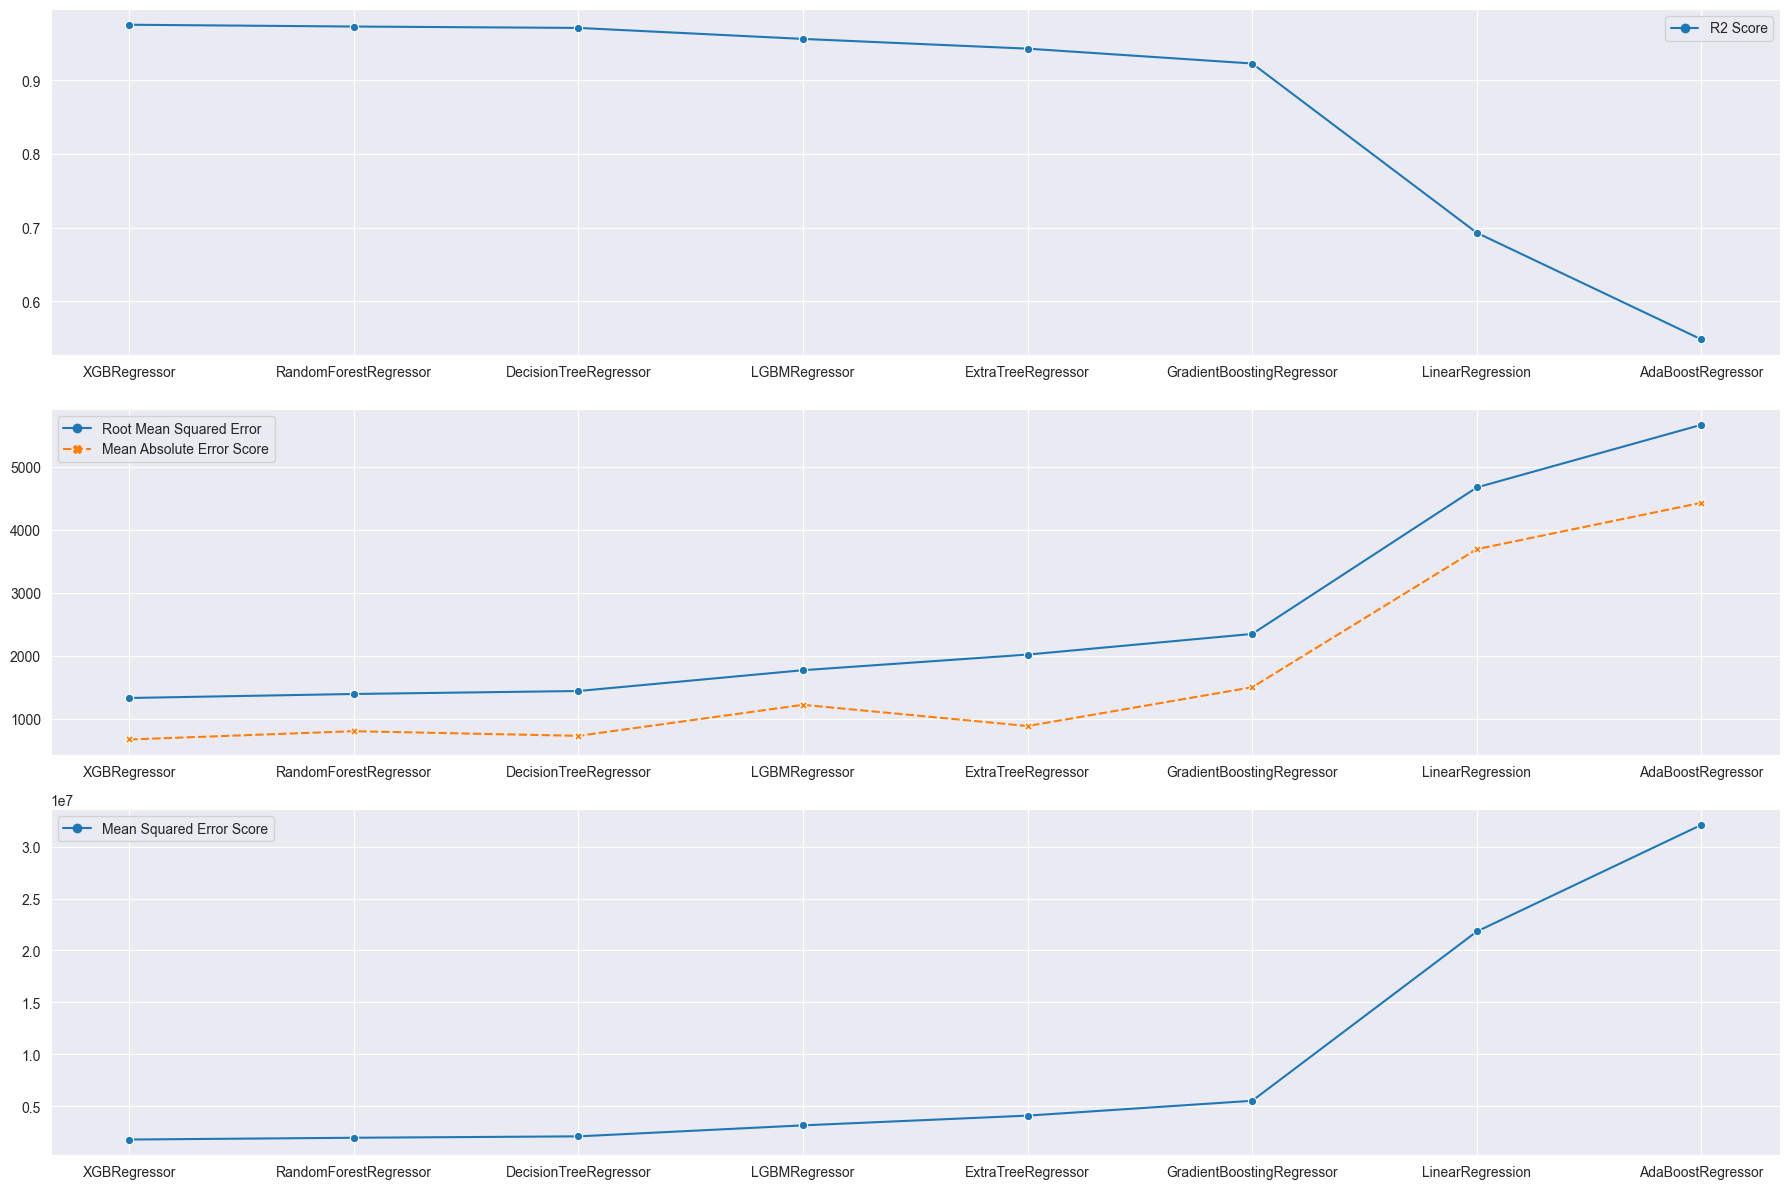

In [86]:
fig,ax=plt.subplots(3,1,figsize=(18,12))
sns.lineplot(data=score_pd.iloc[:,[1,2]],markers=True,ax=ax[1])
sns.lineplot(data=score_pd.iloc[:,[0]],markers=True,ax=ax[0])
sns.lineplot(data=score_pd.iloc[:,[3]],markers=True,ax=ax[2])
plt.tight_layout()
plt.show()

In [87]:
score_pd.iloc[[0],:]

,R2 Score,Root Mean Squared Error,Mean Absolute Error Score,Mean Squared Error Score,model_index
XGBRegressor,0.975148,1329.160943,670.191153,1.766669e+06,5.0


In [88]:
win_index=int(score_pd.iloc[0,-1])
win_index

5

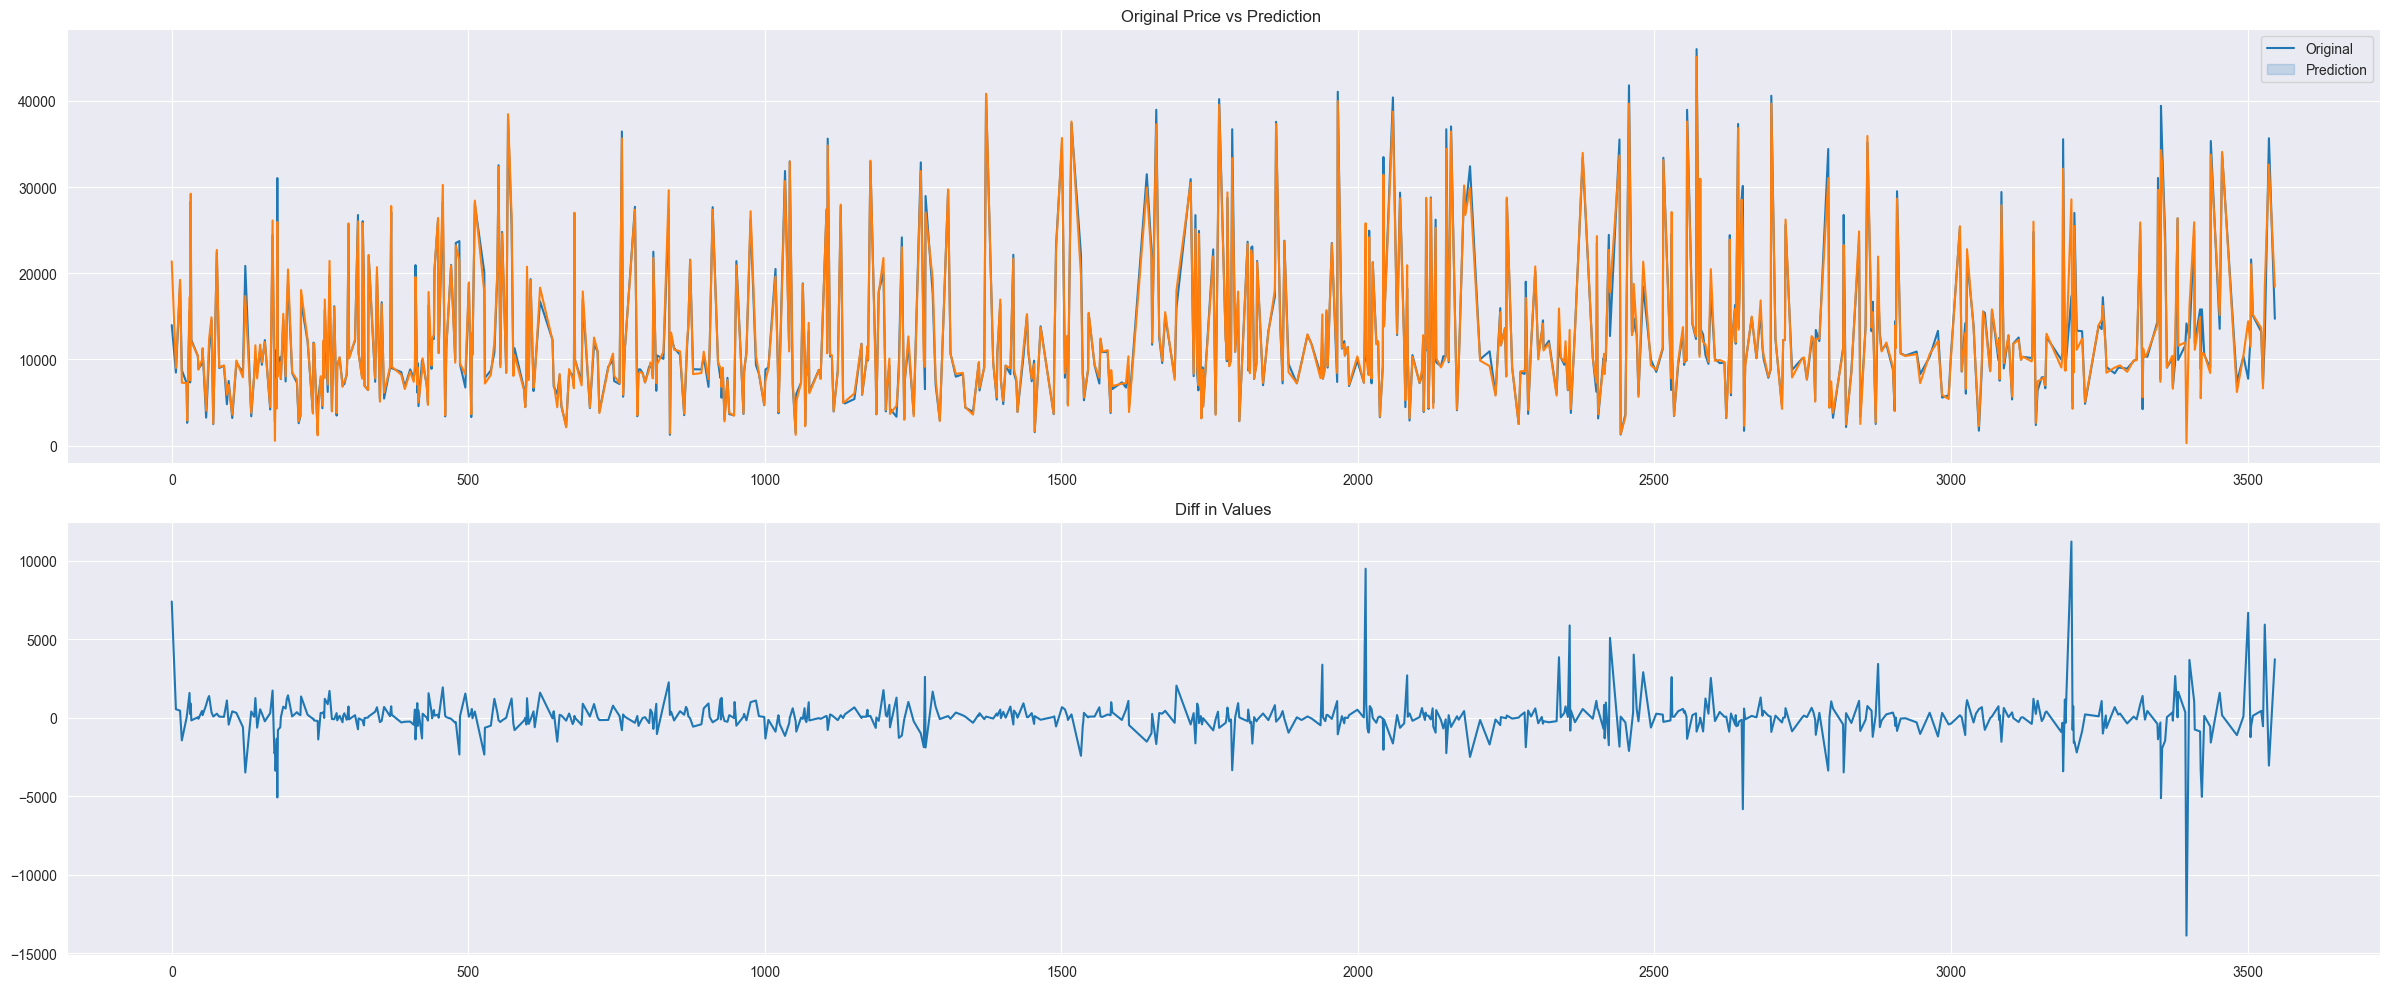

In [89]:
pred=reg_list[win_index].predict(X_test)
diff=pred-y_test.values.ravel()
fig,ax=plt.subplots(2,1,figsize=(24,10))
sns.lineplot(y=y_test.values.ravel(),x=y_test.index,legend=False,ax=ax[0])
sns.lineplot(y=pred,x=y_test.index,legend=False,ax=ax[0])
sns.lineplot(y=diff,x=y_test.index,legend="full",ax=ax[1])
ax[0].set_title('Original Price vs Prediction ')
ax[0].legend(['Original','Prediction'])
ax[1].set_title('Diff in Values')
plt.tight_layout()
plt.show()